# 1. Business Understanding

Airbnb, Inc. is an American company providing an online marketplace for short- and long-term homestays and experiences. Acting as a broker, it charges a commission on each booking. Founded in 2008 by Brian Chesky, Nathan Blecharczyk, and Joe Gebbia, Airbnb evolved from its original name, AirBedandBreakfast.com. It is the leading platform for short-term housing rentals. - Taken from Airbnb's Wikipedia page. Using the dataset Provided, we will dive into the following business questions

The project structure was took from the study based by Alexander Hipp, and you can deep dive on his study on the 
- https://github.com/AlexanderHipp/airbnb-seattle-udacity-project/blob/master/airbnb-sesattle-udacity-project.ipynb

## Pricing Trends

- How do prices vary by season, and when is the peak season in Seattle?
- How do prices differ by neighborhood, and which neighborhoods in Seattle are the most expensive?
- How do different property types within neighborhoods affect prices, particularly in the priciest neighborhoods and for the most common property types?


## Sentiment Analysis of Reviews



- How can we categorize reviews based on sentiment?
- Can we map positive and negative sentiments from reviews to neighborhoods to determine which ones have higher positive sentiment and which have higher negative sentiment?
- Can we analyze some of the worst reviews for additional insights?

## Price Prediction

- Can we predict the price of a given listing? What listing factors are most strongly correlated with price predictions?

Understanding pricing trends can help identify peak seasons and expensive neighborhoods in Seattle, allowing Airbnb to manage inventory and optimize marketing strategies.

Sentiment analysis of reviews can provide insights into brand perception and customer satisfaction. Mapping sentiments to neighborhoods can highlight areas with recurring issues and those that are well-regarded.

Price prediction helps identify the factors most strongly correlated with listing prices, enabling Airbnb and hosts to focus on key features that influence pricing.

# 2. Data Understanding

In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
#load the 3 main datasets
df_calendar = pd.read_csv('./calendar.csv')
df_reviews = pd.read_csv('./reviews.csv')
df_listings = pd.read_csv('./listings.csv')


## df_calendar - Data understanding

In [3]:
df_calendar

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN


In [4]:
df_calendar.shape

(1393570, 4)

In [5]:
df_calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [6]:
df_calendar[(df_calendar['available'] == 't') & (df_calendar['price'].isna())].shape[0]


0

In [7]:
df_calendar[(df_calendar['available'] == 'f') & (df_calendar['price'].isna())].shape[0]

459028

In [8]:
df_calendar.describe(include='all')

,listing_id,date,available,price
count,1.393570e+06,1393570,1393570,934542
unique,NaN,365,2,669
top,NaN,2016-01-04,t,$150.00
freq,NaN,3818,934542,36646
mean,5.550111e+06,NaN,NaN,NaN
std,2.962274e+06,NaN,NaN,NaN
min,3.335000e+03,NaN,NaN,NaN
25%,3.258213e+06,NaN,NaN,NaN
50%,6.118244e+06,NaN,NaN,NaN
75%,8.035212e+06,NaN,NaN,NaN


In [9]:
df_calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

*Findings*
- The Calendar DF doesn't require a lot of data preparation. 
- The date is still in object and we should transform it to date, the only  missing values are in the price column whenever the column "available" is f, which could indicate that in that date the apartment was not available.

## df_listings - Data understanding

In [10]:
df_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,https://www.airbnb.com/rooms/8101950,20160104002432,2016-01-04,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,none,We're located near lots of family fun. Woodlan...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,8,0.30
3814,8902327,https://www.airbnb.com/rooms/8902327,20160104002432,2016-01-04,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,none,The neighborhood is a quiet oasis that is clos...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.00
3815,10267360,https://www.airbnb.com/rooms/10267360,20160104002432,2016-01-04,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3816,9604740,https://www.airbnb.com/rooms/9604740,20160104002432,2016-01-04,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,none,Madison Park offers a peaceful slow pace upsca...,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN


In [11]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [12]:
df_listings.shape

(3818, 92)

In [13]:
df_listings.isnull().sum()[df_listings.isnull().sum() > 0 ]

summary                         177
space                           569
neighborhood_overview          1032
notes                          1606
transit                         934
thumbnail_url                   320
medium_url                      320
xl_picture_url                  320
host_name                         2
host_since                        2
host_location                     8
host_about                      859
host_response_time              523
host_response_rate              523
host_acceptance_rate            773
host_is_superhost                 2
host_thumbnail_url                2
host_picture_url                  2
host_neighbourhood              300
host_listings_count               2
host_total_listings_count         2
host_has_profile_pic              2
host_identity_verified            2
neighbourhood                   416
zipcode                           7
property_type                     1
bathrooms                        16
bedrooms                    

In [14]:
len(df_listings.isnull().sum()[df_listings.isnull().sum() > 0 ])

45

In [15]:
#since we want to answer how differ prices by neighborhood, lets take a closer look into the "host_neighbourhood" feature
list(df_listings['host_neighbourhood'].drop_duplicates())

['Queen Anne',
 nan,
 'Ballard',
 'Belltown',
 'Phinney Ridge',
 'Alki',
 'Fremont',
 'Holly',
 'Lower Queen Anne',
 'Green Lake',
 'Eastlake',
 'Ravenna',
 'Westlake',
 'Columbia City',
 'South Park',
 'Kaanapali',
 'Wallingford',
 'Capitol Hill',
 'Long Beach',
 'Northwest District',
 'Waianae Coast',
 'Minor',
 'Magnolia',
 'Madrona',
 'Harrison/Denny-Blaine',
 'Leschi',
 'University District',
 'Roosevelt',
 'Mission District',
 'Madison Park',
 'Stevens',
 'Central San Pedro',
 'Atlantic',
 'North Beacon Hill',
 'Central Business District',
 'Pike Place Market',
 'Portage Bay',
 'South Lake Union',
 'Fenway/Kenmore',
 'East Village',
 'Clairemont Mesa East',
 'Forestland',
 'Hollywood',
 'Manhattan Beach',
 'Downtown Toronto',
 'International District',
 'Yesler Terrace',
 'First Hill',
 'Anaheim',
 'Maple Leaf',
 'Seward Park',
 'Pioneer Square',
 'Gatewood',
 'The Junction',
 'North Admiral',
 'Arbor Heights',
 'North Hollywood',
 'Kauaʻi',
 'Genesee',
 'Crown Hill',
 'Interbay'

In [16]:
df_listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

In [17]:
df_listings['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

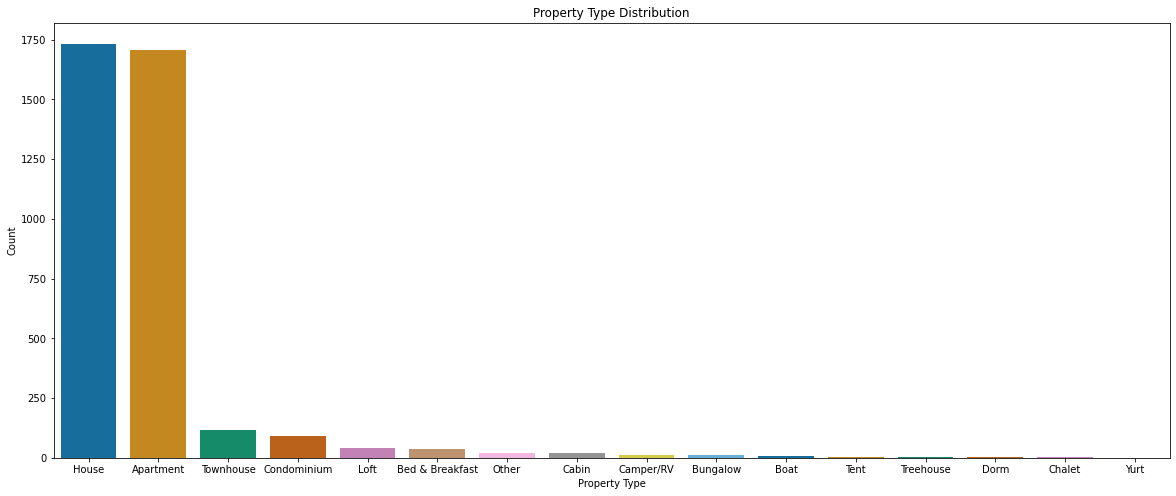

In [18]:



property_counts = df_listings['property_type'].value_counts().reset_index()
property_counts.columns = ['property_type', 'count']

plt.figure(figsize=(20, 8))
sns.barplot(data=property_counts, x='property_type', y='count', palette='colorblind', label=True)

plt.title('Property Type Distribution')
plt.xlabel('Property Type')
plt.ylabel('Count')

plt.show()


*Findings*
- The host_neighbourhoodcolumn seems to be standardized already to use it in analysis and it has 300 null values out of the 3818 rows. 
- The neighbourhood_group_cleansed column seems to be a column that someone has already done some data preparation around it and has no NaN values and only the main neighbourhoods, which could be useful for our analysis to simplify it.
- The property_type column has only one null value
- The dataframe has 45 columns which contains at least one null value and we have to take these columns into consideration depending on how our analysis develop below
- House and Apartment property types are the majority of the listing in the city

## df_reviews - Data understanding

In [19]:
df_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del..."
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si..."


In [20]:
df_reviews.shape

(84849, 6)

In [21]:
df_reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [22]:
df_reviews.describe()

,listing_id,id,reviewer_id
count,8.484900e+04,8.484900e+04,8.484900e+04
mean,3.005067e+06,3.058765e+07,1.701301e+07
std,2.472877e+06,1.636613e+07,1.353704e+07
min,4.291000e+03,3.721000e+03,1.500000e+01
25%,7.946330e+05,1.725127e+07,5.053141e+06
50%,2.488228e+06,3.228809e+07,1.413476e+07
75%,4.694479e+06,4.457648e+07,2.762402e+07
max,1.024814e+07,5.873651e+07,5.281274e+07


In [23]:
df_reviews.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

*Findings*
- the dataframa doesnt have null values apparently and wont need much data preparation
- the date column is in object and we should cast it to date to work with it properly

# 3. Data Preparation

1. How do prices vary by season, and when is the peak season in Seattle?
2. How do prices differ by neighborhood, and which neighborhoods in Seattle are the most expensive?
3. How do different property types within neighborhoods affect prices, particularly in the priciest neighborhoods and for the most common property types?


In [24]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

df_calendar['price'] = df_calendar['price'].apply(lambda x: np.nan if pd.isna(x) or x == 'NaN' else float(str(x).replace('$', '').replace(',', '')))
df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month

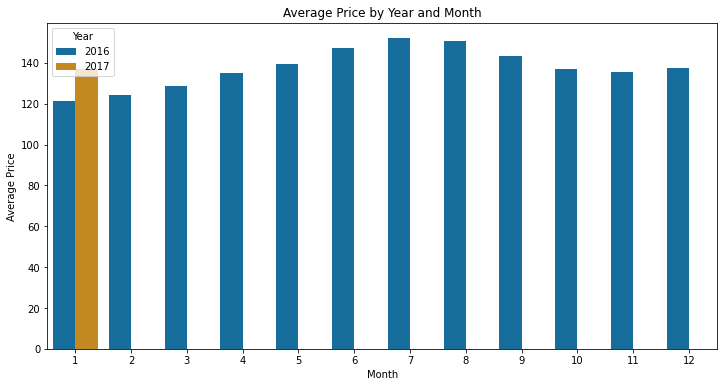

In [25]:
#investigation for question one
avg_price_per_month = df_calendar.groupby(['year', 'month'], as_index=False)['price'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='price', hue='year', data=avg_price_per_month, palette='colorblind')

plt.title('Average Price by Year and Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.legend(title='Year')
plt.show()

In [26]:
#investigation for question 2
df_listings['price'] = df_listings['price'].apply(lambda x: np.nan if pd.isna(x) or x == 'NaN' else float(str(x).replace('$', '').replace(',', '')))

df_listings.groupby(by='neighbourhood_cleansed').agg({'price' : "mean"}).sort_values(by='price', ascending=False).reset_index()

,neighbourhood_cleansed,price
0,Southeast Magnolia,231.705882
1,Portage Bay,227.857143
2,Westlake,194.470588
3,West Queen Anne,187.769231
4,Montlake,182.789474
...,...,...
82,North Delridge,76.375000
83,Georgetown,76.125000
84,South Delridge,74.666667
85,Olympic Hills,71.687500


In [27]:
#investigation for question 3
most_expen_neighbor = list(df_listings.groupby(by='neighbourhood_cleansed').agg({'price' : "mean"}).sort_values(by='price', ascending=False).reset_index().head(5)['neighbourhood_cleansed'])
main_property_types = ('Apartment','House')

df_listings_q3 = df_listings.loc[df_listings['neighbourhood_cleansed'].isin(most_expen_neighbor)]
df_listings_q3 = df_listings_q3.loc[df_listings['property_type'].isin(main_property_types)]

df_listings_q3np = df_listings_q3.groupby(['neighbourhood_cleansed','property_type'])[['price']].mean().reset_index()




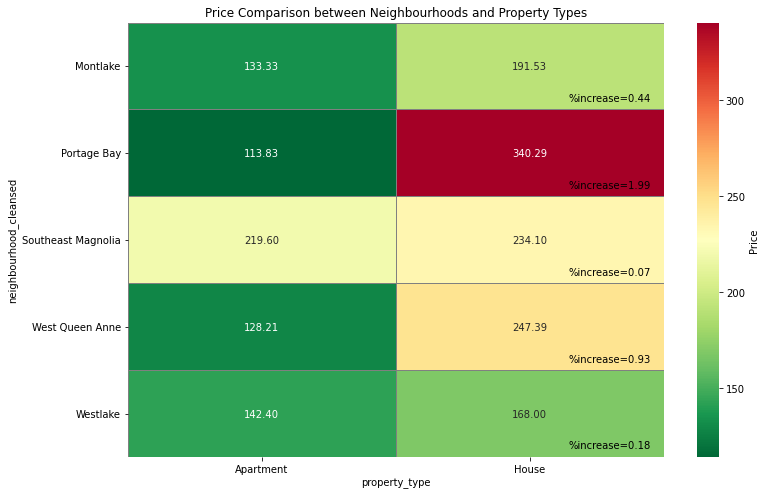

In [28]:
df_diff = df_listings_q3np.pivot('neighbourhood_cleansed', 'property_type', 'price')


plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_diff, annot=True, fmt=".2f", cmap="RdYlGn_r", linewidths=.5, linecolor='gray', cbar_kws={'label': 'Price'})
df_diff['Difference'] = (df_diff['House'] - df_diff['Apartment']) / df_diff['Apartment']
for y in range(df_diff.shape[0]):
    for x in range(df_diff.shape[1]):
        if df_diff.columns[x] == 'House':
            diff = df_diff.iloc[y, 2]  
            ax.text(x + 0.8, y + 0.8, f'\n%increase={diff:.2f}', color='black', ha='center', va='center', fontsize=10)

plt.title('Price Comparison between Neighbourhoods and Property Types')
plt.show()

*Findings*
- Q1 - Prices seem to vary by season, and around summer prices have a higher average price if compared to the other seasons
- Q2 - Prices tend to vary by neighbourhood aswell, with Southeast Magnolia, Portage Bay and Westlake having an average price of 231.71, 227.86 and 194.47, respectively. On the other hand, the cheapest neighborhood are around the 70 usd per day
- Q3 - Focusing on the most expensive neighborhoods, we can see that House Prices tend to be higher than apartment prices. It is interesting to note that these prices usually never surpass the 100% increase, with the exception of Portgage Bay, where prices increased by 200% and house prices in this neighboorhood are the highest, with 340.

# 4. Modeling

## Feature Creation

- Can we predict the price of a given listing? What listing factors are most strongly correlated with price predictions?

In [29]:
cols_less_impact = ['id','listing_url','scrape_id','last_scraped','thumbnail_url','medium_url','xl_picture_url','host_id','host_url','host_thumbnail_url','host_verifications','street','neighbourhood','neighbourhood_group_cleansed','zipcode','smart_location','country','latitude','longitude','weekly_price','monthly_price','calendar_updated','calendar_last_scraped','first_review','last_review','calculated_host_listings_count','reviews_per_month','picture_url','host_picture_url','jurisdiction_names']
df_list = df_listings.drop(cols_less_impact, axis=1)
df_list.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'city', 'state',
       'market', 'country_code', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_clean

In [30]:
#Removing columns with all missing values or constant columns
columns_to_drop1 = df_list.columns[df_list.isna().all()]
columns_to_drop2 = df_list.columns[df_list.nunique() == 1]

columns_to_drop = columns_to_drop1.union(columns_to_drop2)

df_list = df_list.drop(columns=columns_to_drop)

In [31]:
 df_list.select_dtypes(include=['number']).isnull().sum()

host_listings_count               2
host_total_listings_count         2
accommodates                      0
bathrooms                        16
bedrooms                          6
beds                              1
square_feet                    3721
price                             0
guests_included                   0
minimum_nights                    0
maximum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating            647
review_scores_accuracy          658
review_scores_cleanliness       653
review_scores_checkin           658
review_scores_communication     651
review_scores_location          655
review_scores_value             656
dtype: int64

 - bathrooms - There are 16 rows with Nan for bathrooms. Since it's a small percentage of rows, I have decided to set bathrooms to 1 for Nan values. For all listings on Airbnb, guests require access to a bathroom that has a sink, toilet, and shower or tub, so in these cases I am assuming at least one.

- bedrooms - Every row with a NaN bedroom field have beds of at least one. So i am populating these with one

- beds - For the 1 record that have beds as Nan, bed_type is specified as Real Bed, so I will set beds to 1 for this case.

- square_feet - Almost every record is in blank. So we will drop this column.

- review_scores columns - Since these are review related scores, I will be setting all Nan values to 0 assuming no review scores for these listings.

- host_listings_count and host_total_listings_count - There are only 2 rows with no values. Looking at the data, I determined that these host IDs only have 1 record associated with them each, so I decided to populate with 1.

In [32]:
# Set 0 for bathroom where bathroom is Nan
df_list['bathrooms'] = df_list['bathrooms'].fillna(1)

# Set 1 for bedrooms where bedrooms is Nan
df_list['bedrooms'] = df_list['bedrooms'].fillna(1)

# Set 1 for beds where beds is Nan
df_list['beds'] = df_list['beds'].fillna(1)


# Drop square_feet column
df_list = df_list.drop('square_feet',axis=1)



# Set all review scores columns with 0 for Nan values
cols_fillna_0 = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
for col in cols_fillna_0:
    df_list[col] = df_list[col].fillna(0)
    
    
# Set host_listings_count and host_total_listings_count to 1
df_list['host_listings_count'] = df_list['host_listings_count'].fillna(1)
df_list['host_total_listings_count'] = df_list['host_total_listings_count'].fillna(1)

In [33]:
#Checking the categorical columns with missing values now 
df_list.select_dtypes(include=['object']).isnull().sum()[df_list.select_dtypes(include=['object']).isnull().sum() >0]

summary                    177
space                      569
neighborhood_overview     1032
notes                     1606
transit                    934
host_name                    2
host_since                   2
host_location                8
host_about                 859
host_response_time         523
host_response_rate         523
host_acceptance_rate       773
host_is_superhost            2
host_neighbourhood         300
host_has_profile_pic         2
host_identity_verified       2
property_type                1
security_deposit          1952
cleaning_fee              1030
dtype: int64

In [34]:
#Checking the categorical columns without missing values
df_list.select_dtypes(include=['object']).isnull().sum()[df_list.select_dtypes(include=['object']).isnull().sum() ==0]

name                                0
description                         0
neighbourhood_cleansed              0
city                                0
state                               0
is_location_exact                   0
room_type                           0
bed_type                            0
amenities                           0
extra_people                        0
instant_bookable                    0
cancellation_policy                 0
require_guest_profile_picture       0
require_guest_phone_verification    0
dtype: int64

- summary, space, neighborhood_overview, notes, transit - these are all descriptions of the property. We will create boolean fields based on these features to try to see if properties with a description have an impact on their price prediction. - ok

- host_name, host_since, host_location, host_about, host_picture_url, host_neighbourhood - I am also converting these to boolean, since these are descriptions about the host. - ok

- host_response_time, host_acceptance_rate - When these fields are N/A, they can actually pass a message to the user. So I will create a category called N/A for these fields - ok

- host_response_rate - Looking at the data, since this is a percentage value and the range is quite distributed, I will be converting this to float and setting N/A and blanks to 0

- host_is_superhost, host_has_profile_pic, host_identity_verified - These are boolean fields with t or f values. Assign 1 for t, 0 for f and assign Nans with 0 - ok

- property_type - Since this is just 1 record, we will just drop this record - ok

- security_deposit - We will assume a 0 security deposit for where it is not specified. We will also remove dollar signs and convert to float - ok

- cleaning_fee - We will assume a 0 cleaning_fee where it is not specified. We will also remove dollar signs and convert to float - ok



###### The following fields do not have missing values, but it is important to cleanse these as well.

- name, description, picture_url - these are also descriptive fields and will get the same treatment as summary, space, neighborhood_overview, notes, transit. - ok

- is_location_exact, requires_license, instant_bookable, require_guest_profile_picture, require_guest_phone_verification - these fields have t/f values, will convert to 1/0. - ok

- extra_people - Need to remove dollar sign and convert to float - ok


- city - This field has almost all rows with "Seattle" as value and 6 other types of calling the city name, like "seattle", "Seattle ", or "West Seattle". This doesn't add much information too, and we will drop this column

- state - There are both "WA" and "wa" values for state. his doesn't add much information too, and we will drop this column

- amenities - this field contains a list of values in each row, we will need to figure out how to handle this column




In [35]:
def set_bool_text(textdata):
    if not textdata or pd.isna(textdata):
        return 0
    else:
        return 1

text_fields = ['summary','space','neighborhood_overview','notes','transit','name','description','host_name','host_since','host_location','host_about','host_neighbourhood']
for t in text_fields:
    df_list[t] = df_list[t].apply(set_bool_text)

In [36]:
# Function to set all t/f fields to 1/0
def set_bool_tf(tfdata):
    if tfdata == 't':
        return 1
    else: 
        return 0

tf_fields = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
for t in tf_fields:
    df_list[t] = df_list[t].apply(set_bool_tf)

In [38]:
df_list['host_response_time'] = df_list['host_response_time'].fillna('N/A')
df_list['host_acceptance_rate'] = df_list['host_acceptance_rate'].fillna('N/A')

df_list['host_response_rate'] = df_list['host_response_rate'].fillna(0)
df_list['host_response_rate'] = df_list['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
df_list['host_response_rate'].drop_duplicates()

df_list = df_list.dropna(subset=['property_type'], axis=0)



columns = ['security_deposit', 'cleaning_fee', 'extra_people']

# Loop through the columns and apply the transformations
for col in columns:
    df_list[col] = df_list[col].replace('[\$,]', '', regex=True).astype(float).fillna(0)
    
    
df_list = df_list.drop(['city','state'], axis = 1)


###### Handling Amenities

In [45]:
from collections import Counter

# Process amenities and count occurrences
amenities = [amenity for row in df_list['amenities'].str.replace('{', '').str.replace('}', '').str.replace('"', '')
             for amenity in row.split(',')]

amenities_count = Counter(amenities)
most_common_amenities = amenities_count.most_common()
most_common_amenities

C:\Users\RENAN~1.PAR\AppData\Local\Temp/ipykernel_17356/3402003421.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  amenities = [amenity for row in df_list['amenities'].str.replace('{', '').str.replace('}', '').str.replace('"', '')


[('Wireless Internet', 3666),
 ('Heating', 3626),
 ('Kitchen', 3422),
 ('Smoke Detector', 3280),
 ('Essentials', 3237),
 ('Dryer', 2996),
 ('Washer', 2991),
 ('Internet', 2811),
 ('Shampoo', 2670),
 ('TV', 2574),
 ('Carbon Monoxide Detector', 2485),
 ('Fire Extinguisher', 2196),
 ('Free Parking on Premises', 2166),
 ('Family/Kid Friendly', 1962),
 ('First Aid Kit', 1679),
 ('Cable TV', 1446),
 ('Indoor Fireplace', 885),
 ('Pets live on this property', 882),
 ('Hangers', 846),
 ('Elevator in Building', 785),
 ('Hair Dryer', 774),
 ('Laptop Friendly Workspace', 745),
 ('Iron', 742),
 ('Safety Card', 727),
 ('Air Conditioning', 677),
 ('24-Hour Check-in', 616),
 ('Buzzer/Wireless Intercom', 538),
 ('Dog(s)', 508),
 ('Pets Allowed', 472),
 ('Gym', 442),
 ('Cat(s)', 382),
 ('Hot Tub', 303),
 ('Wheelchair Accessible', 300),
 ('Breakfast', 291),
 ('Suitable for Events', 209),
 ('Pool', 159),
 ('Lock on Bedroom Door', 100),
 ('Doorman', 85),
 ('Smoking Allowed', 82),
 ('Other pet(s)', 50),
 ('

In [51]:
# Step 1: Identify amenities that appear at least 100 times
common_amenities = [amenity for amenity, count in amenities_count.items() if count >= 100]

# Step 2: Create a boolean column for each common amenity
for amenity in common_amenities:
    df_list[amenity] = df_list['amenities'].apply(lambda x: 1 if amenity in x else 0)

df_list = df_list.drop('amenities', axis = 1)



- I decided to take those amenities that are 100 times. Taking only the amenities that appear frequently could hide some amenities that are not present very often, but when they do, they have an impact on the Price Predicted
- Now, Finally, we need to create dummies for the categorical fields remaining and we are then prepared for modeling

In [53]:
df_list.select_dtypes(include=['object']).columns


Index(['host_response_time', 'host_acceptance_rate', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'bed_type', 'cancellation_policy'],
      dtype='object')

In [55]:
# Get Dummies for categorical fields
cat_fields = df_list.select_dtypes(include=['object']).columns

df_list = pd.get_dummies(df_list, columns=cat_fields)
df_list.head()

,name,summary,space,description,neighborhood_overview,notes,transit,host_name,host_since,host_location,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,1,0,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,1,0,1,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,1
3,1,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,1


## Model Creation

In [59]:
# Build out X and y, y to be price column and X to be all the other columns
y = df_list['price']
X = df_list.drop(['price'], axis=1)


# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2671, 203) (2671,)
(1146, 203) (1146,)


In [61]:
# Instantiate linear regression model and fit it to training data set
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 
        
# Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test) 
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test,y_test_preds)
print("The rsquared score on the training data was {}.  The rsquared score on the test data was {}.".format(train_score, test_score))

The rsquared score on the training data was 0.5910990554692732.  The rsquared score on the test data was 0.5720830021022858.


To assess how important a feature is, we can examine the model's coefficients. The magnitude of each coefficient indicates the importance of the corresponding feature

In [63]:
# Get the coefficients from the linear model
coefficients = lm_model.coef_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

                                  Feature    Importance
3                             description  3.345273e+16
7                               host_name  1.343418e+16
8                              host_since  1.343418e+16
83        host_response_time_within a day  2.968898e+15
82  host_response_time_a few days or more  2.968898e+15
..                                    ...           ...
32                       availability_365  2.063623e-02
27                         minimum_nights  1.715997e-02
11                     host_response_rate  1.184660e-02
28                         maximum_nights  1.055081e-03
31                        availability_90  5.628047e-04

[203 rows x 2 columns]


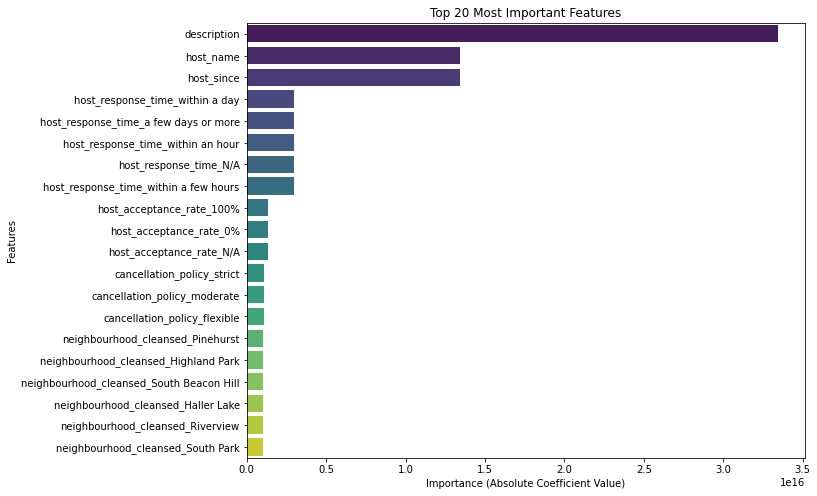

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importance(feature_importance, top_n=10, include_others=True):
    '''
    Plots the top N most important features in a bar chart and optionally includes an "Others" bar.

    Parameters:
    feature_importance (DataFrame): DataFrame containing feature names and their importance values.
    top_n (int): Number of top features to display.
    include_others (bool): Whether to include a bar for the "Others" category.

    Returns:
    None
    '''
    
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    top_features = feature_importance.head(top_n)

    if include_others:
        others_importance = feature_importance.iloc[top_n:]['Importance'].sum()

        top_features = top_features.append(pd.DataFrame({
            'Feature': ['Others'],
            'Importance': [others_importance]
        }), ignore_index=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

    plt.title(f'Top {top_n} Most Important Features' + (' with "Others"' if include_others else ''))
    plt.xlabel('Importance (Absolute Coefficient Value)')
    plt.ylabel('Features')

    plt.show()

plot_feature_importance(feature_importance, top_n=20, include_others=False)


The R2 Score achieved was 0.57 for the test data. By analising the most important features, we can see that the most important features are a combination of the descriptive features about the listing and the host and how the host behaves towards possible listings, like its response_time delay, acceptance_rate and cancelation policy. After that, features involving the neighbourhood start having a great impact.